In [1]:

# import libraries
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from nltk.stem.porter import *
from collections import defaultdict
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score,accuracy_score

In [2]:
# nltk.download("all")

In [3]:
# Load the amazon review dataset
df = pd.read_csv('../data/IMDB Dataset.csv')

In [4]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
df.shape

(50000, 2)

In [6]:
# df = df[:20000]

In [7]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [8]:
train, test = train_test_split(df,test_size=0.30, shuffle= True)

In [9]:
def preprocess_text(text:str):
    
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    tokens = word_tokenize(text.lower())

    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    stemmer =  PorterStemmer()
    
    stopwords_set = set(stopwords.words("english"))
    
    tokens_2 = [stemmer.stem(token) for token in filtered_tokens if token not in stopwords_set]

    return tokens_2

In [10]:
train

,review,sentiment
23330,This is one of the most underrated masterpiece...,positive
24758,"Like its near contemporaries ""The Great Race"" ...",negative
11964,Don't be taken in because the premise of this ...,negative
36831,Saxophonist Ronnie Bowers (Dick Powell) wins a...,positive
42981,This is about a mad scientist who creates a ha...,positive
...,...,...
49668,I really liked this movie...it was cute. I enj...,positive
9198,"<br /><br />Cheap-looking and ugly, this film ...",negative
46672,I feel very strongly that this film was just l...,positive
1228,Although the premise of the movie involves a m...,positive


In [11]:
def calculate_word_counts(reviews):
    word_count = defaultdict(int)
    
    for review in reviews:
        tokens = preprocess_text(review)
        
        for token in tokens:
            word_count[token] += 1
    
    return word_count

In [12]:
def calculate_likelihood(word_count, total_words, laplacian_smoothing=1):
    likelihood = {}
    
    vocabulary_size = len(word_count)

    for word, count in word_count.items():
        likelihood[word] = (count + laplacian_smoothing) / (total_words + laplacian_smoothing * vocabulary_size)

    # Return the calculated likelihood dictionary
    return likelihood

In [13]:
def calculate_log_prior(sentiment, data):
    return math.log(len(data[data['sentiment'] == sentiment]) / len(data))

In [14]:
def classify_review_with_scores(review, log_likelihood_positive, log_likelihood_negative,log_prior_positive, log_prior_negative):
    tokens = preprocess_text(review)

    log_score_positive = log_prior_positive + sum([log_likelihood_positive.get(token, 0) for token in tokens])
    log_score_negative = log_prior_negative + sum([log_likelihood_negative.get(token, 0) for token in tokens])

    sentiment_scores = {
        'positive': log_score_positive,
        'negative': log_score_negative
    }

    predicted_sentiment = max(sentiment_scores, key=sentiment_scores.get)
    return predicted_sentiment, sentiment_scores

In [15]:
word_count_positive = calculate_word_counts(train[train['sentiment'] == 'positive']['review'])
word_count_negative = calculate_word_counts(train[train['sentiment'] == 'negative']['review'])

total_positive_words = sum(word_count_positive.values())
total_negative_words = sum(word_count_negative.values())

likelihood_positive = calculate_likelihood(word_count_positive, total_positive_words)
likelihood_negative = calculate_likelihood(word_count_negative, total_negative_words)

positive = calculate_log_prior('positive', train)
negative = calculate_log_prior('negative', train)

log_likelihood_positive = {word: math.log(prob) for word, prob in likelihood_positive.items()}
log_likelihood_negative = {word: math.log(prob) for word, prob in likelihood_negative.items()}

In [16]:
correct_predictions = 0
total_predictions = len(test)
y_pred = []

for index, row in test.iterrows():
    predicted_sentiment, sentiment_scores = classify_review_with_scores(
        row['review'], log_likelihood_positive, log_likelihood_negative,
        positive, negative,
    )
    y_pred.append(predicted_sentiment)

In [17]:
test['sentiment']

11892    positive
23908    negative
25506    negative
20745    negative
5109     negative
           ...   
24430    negative
33515    negative
32554    negative
15650    negative
47022    negative
Name: sentiment, Length: 15000, dtype: object

In [18]:
len(y_pred)

15000

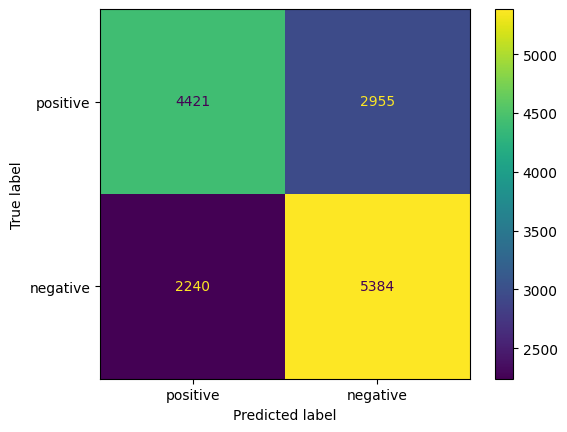

In [19]:
confusion_matr = confusion_matrix(test['sentiment'], y_pred, labels=['positive', 'negative'])

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matr, display_labels = ['positive', 'negative'])

cm_display.plot()
plt.show() 

In [20]:
accuracy_score(test['sentiment'], y_pred)

0.6536666666666666

In [21]:
precision_score(test['sentiment'], y_pred,average='macro')

0.6546775605889301

# Use to generate interactions with choosed words

In [22]:
# import json

# score = {}
# df_original = pd.read_csv('./data/IMDB Dataset.csv')
# for i in [5000,10000,15000,20000,25000,30000,40000,45000,50000]:
#     # Load the amazon review dataset
#     df = df_original.sample(i)

#     train, test = train_test_split(df,test_size=0.30, shuffle= True)

#     word_count_positive = calculate_word_counts(train[train['sentiment'] == 'positive']['review'])
#     word_count_negative = calculate_word_counts(train[train['sentiment'] == 'negative']['review'])

#     total_positive_words = sum(word_count_positive.values())
#     total_negative_words = sum(word_count_negative.values())

#     likelihood_positive = calculate_likelihood(word_count_positive, total_positive_words)
#     likelihood_negative = calculate_likelihood(word_count_negative, total_negative_words)

#     positive = calculate_log_prior('positive', train)
#     negative = calculate_log_prior('negative', train)

#     log_likelihood_positive = {word: math.log(prob) for word, prob in likelihood_positive.items()}
#     log_likelihood_negative = {word: math.log(prob) for word, prob in likelihood_negative.items()}


#     ###############################################
#     #PREDICT#
#     ###############################################


#     correct_predictions = 0
#     total_predictions = len(test)
#     y_pred = []

#     for index, row in test.iterrows():
#         predicted_sentiment, sentiment_scores = classify_review_with_scores(
#             row['review'], log_likelihood_positive, log_likelihood_negative,
#             positive, negative,
#         )
#         y_pred.append(predicted_sentiment)
        
        
#     ## METRICS
#     precision = precision_score(test['sentiment'], y_pred,average='macro')
#     accuracy = accuracy_score(test['sentiment'], y_pred)
    
#     score[i] = {"precision": precision, "accuracy": accuracy}
    
# with open('results.json', 'w') as f:
#     json.dump(score, f)

In [23]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Open and read the JSON file
with open('results.json', 'r') as file:
    data = json.load(file)

# Print the data
numInteractions = list(data.keys())
lstPrecision = list()
for i in data:
    lstPrecision.append(data[i]["accuracy"])
    
xpoints = np.array(numInteractions)
ypoints = np.array(lstPrecision)

# plt.plot(xpoints, ypoints)
fig, ax = plt.subplots()
ax.plot(xpoints, ypoints, **{'color': 'blue', 'marker': 'o'})
plt.axis([-0.2, 8.5, 0, 0.9])
for i, txt in enumerate(ypoints):
    ax.annotate(f"{txt:.2f}", (xpoints[i], ypoints[i]+ 0.02))
plt.xlabel("Numbers of Reviews")
plt.ylabel("Accuracy")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'results.json'